In [1]:
exp_name = None
exp_output_dir = None
exp_conf_dir = None
filter_code = None
nucleus_plasmid_threshold = .9
enable_graphics = True
enable_single_cell_data = False
export_dir = None

In [2]:
# Parameters
enable_single_cell_data = True
nucleus_plasmid_threshold = 0.9
exp_output_dir = "/lab/data/dna-stain/20180911-stain/20180911-D35-activated-labeled-60X-11by11/output/v00"
export_dir = "/lab/repos/cell-image-analysis/analysis/experiments/dna-stain/plasmid_analysis/renders/20180911-D35-activated-labeled-60X-11by11"
progres_bar = True
filter_code = "df = df[df['cs:Plasmid:class'] == 1]\ndf = df[df['ni:DAPI'] >= 50]\ndf = df[df['nucleus_diameter'].between(2, 15) & df['cell_diameter'].between(5, 20)]\ndf = df[df['cell_circularity'] > .8]\ndf = df[df['ci:PHA'] >= 30]"
exp_conf_dir = "/lab/repos/cell-image-analysis/config/experiment/dna-stain/20180911-stain/20180911-D35-activated-labeled-60X-11by11"
enable_graphics = True
exp_name = "20180911-D35-activated-labeled-60X-11by11"


In [3]:
# # Parameters
# exp_conf_dir = "/lab/repos/cell-image-analysis/config/experiment/dna-stain/20180911-stain/20180911-D35-activated-labeled-60X-11by11"
# enable_graphics = False
# exp_output_dir = "/lab/data/dna-stain/20180911-stain/20180911-D35-activated-labeled-60X-11by11/output/v00"
# filter_code = "df = df[df['cs:Plasmid:class'] == 1]\ndf = df[df['ci:PHA'] >= 30]\ndf = df[df['nucleus_diameter'].between(2, 15) & df['cell_diameter'].between(5, 20)]\ndf = df[df['cell_circularity'] > .8]\ndf = df[df['ni:DAPI'] >= 50]"
# exp_name = "20180911-D35-activated-labeled-60X-11by11"
# nucleus_plasmid_threshold = 0.9
# enable_single_cell_data = True

In [4]:
if filter_code and filter_code.lower() == 'none':
    filter_code = None

In [5]:
assert exp_name, 'Must provide "exp_name" (Experiment Name)'
assert exp_output_dir, 'Must provide "exp_conf_dir" (Experiment Output Directory)'
assert exp_conf_dir, 'Must provide "exp_conf_dir" (Experiment Configuration Directory)'

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as pn
import os.path
import os.path as osp
import papermill as pm
from cytokit import io as cytokit_io
from cytokit import config as cytokit_config
from cytokit.function import data as cytokit_data
from cvutils import encoding
exp_conf = cytokit_config.load(exp_conf_dir)

In [7]:
# Compute size of field of view for experiment in sq mm
sqmm_ppx = (exp_conf.microscope_params.res_lateral_nm / 1e6)**2
sqmm_exp = sqmm_ppx * exp_conf.region_height * exp_conf.region_width * exp_conf.tile_width * exp_conf.tile_height
sqmm_exp

2.5947953519159994

In [8]:
cyto_path = osp.join(exp_output_dir, cytokit_io.get_cytometry_agg_path('csv'))
df = pd.read_csv(cyto_path)
cell_density_raw = len(df) / sqmm_exp

In [9]:
if filter_code is not None:
    local_vars = {'df': df}
    exec(filter_code, globals(), local_vars)
    df = local_vars['df']
cell_density_target = len(df) / sqmm_exp
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262 entries, 18 to 3127
Data columns (total 43 columns):
region_index                          262 non-null int64
tile_index                            262 non-null int64
tile_x                                262 non-null int64
tile_y                                262 non-null int64
rid                                   262 non-null int64
rx                                    262 non-null float64
ry                                    262 non-null float64
id                                    262 non-null int64
x                                     262 non-null float64
y                                     262 non-null float64
z                                     262 non-null int64
cell_size                             262 non-null float64
cell_diameter                         262 non-null float64
cell_perimeter                        262 non-null float64
cell_circularity                      262 non-null float64
cell_solidity         

In [10]:
pm.record('cell_density_raw', cell_density_raw)
pm.record('cell_density_target', cell_density_target)
cell_density_raw, cell_density_target

(1210.1147004450354, 100.97135398617812)

In [11]:
cts = df['cs:Plasmid:plasmid_count'].value_counts().sort_index()
print('Plasmid count distribution:')
pm.record('plasmid_count_dist', cts.to_json())
for i, v in cts.items():
    print(i, '-', v)

print('Num cells total:')
pm.record('total_cells', len(df))
len(df)

Plasmid count distribution:


1 - 146
2 - 67
3 - 20
4 - 14
5 - 12
6 - 2
9 - 1
Num cells total:


262

### Single Cell Export and Visualization

Single cell data frame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 15 columns):
id                         262 non-null int64
rid                        262 non-null int64
tile_x                     262 non-null int64
tile_y                     262 non-null int64
x                          262 non-null float64
y                          262 non-null float64
z                          262 non-null int64
cell_diameter              262 non-null float64
nucleus_diameter           262 non-null float64
cell_circularity           262 non-null float64
nucleus_circularity        262 non-null float64
nucleus_fraction           262 non-null object
nucleus_plasmid_count      262 non-null int64
cytoplasm_plasmid_count    262 non-null int64
image                      262 non-null object
dtypes: float64(6), int64(7), object(2)
memory usage: 30.8+ KB
None
Exporting data frame to csv


<Figure size 432x288 with 0 Axes>

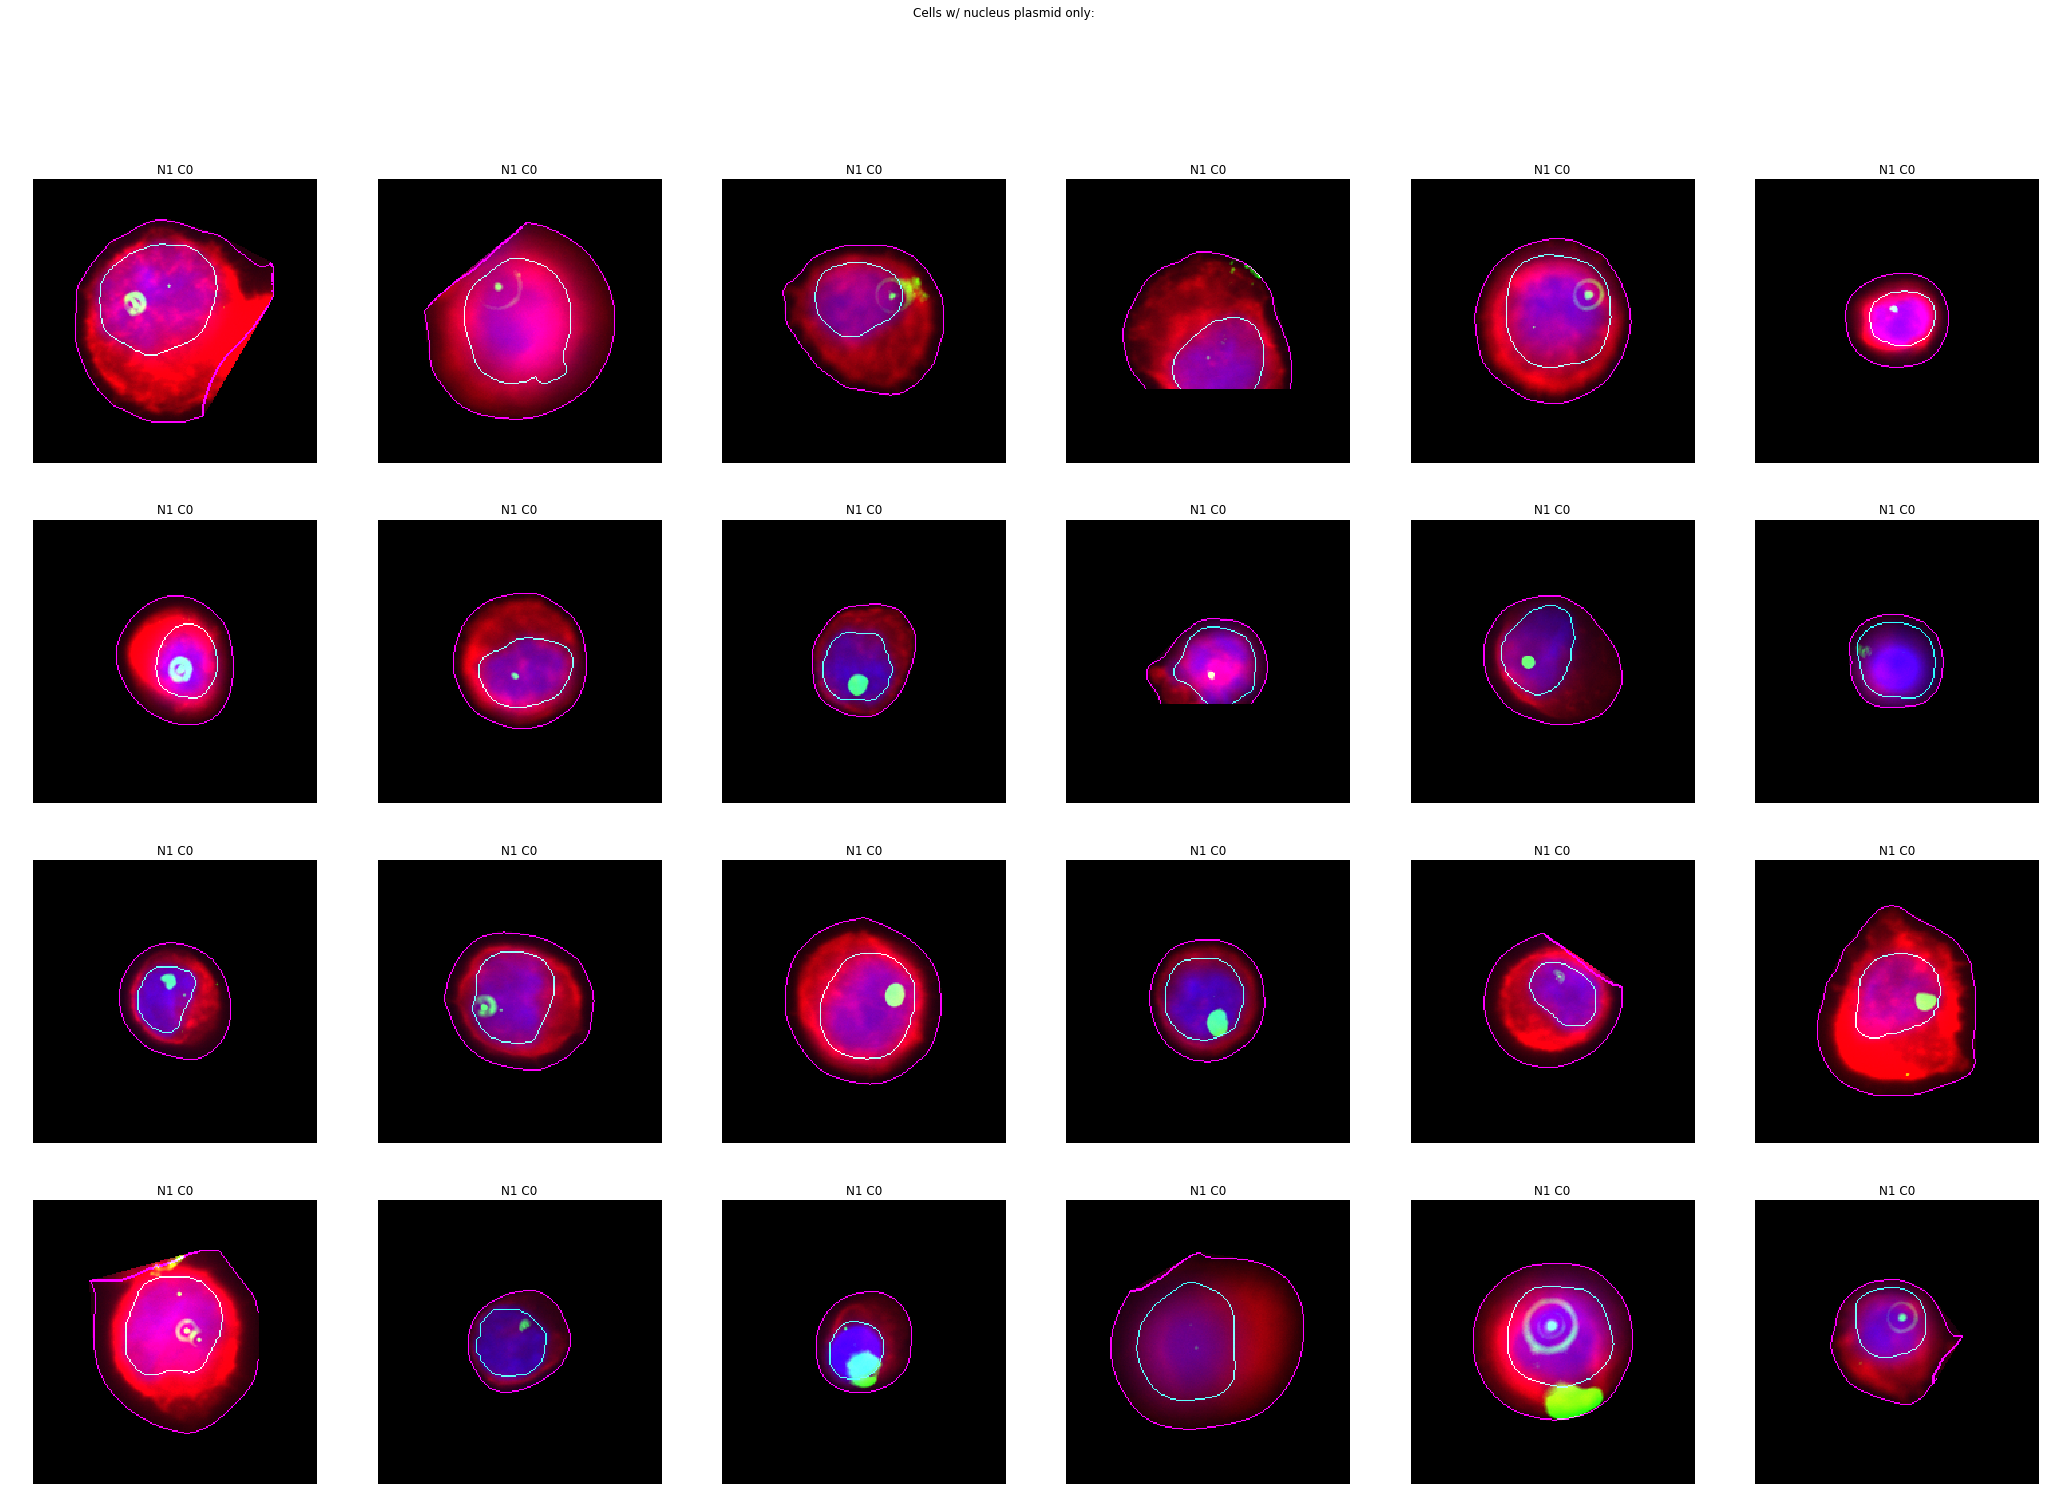

<Figure size 432x288 with 0 Axes>

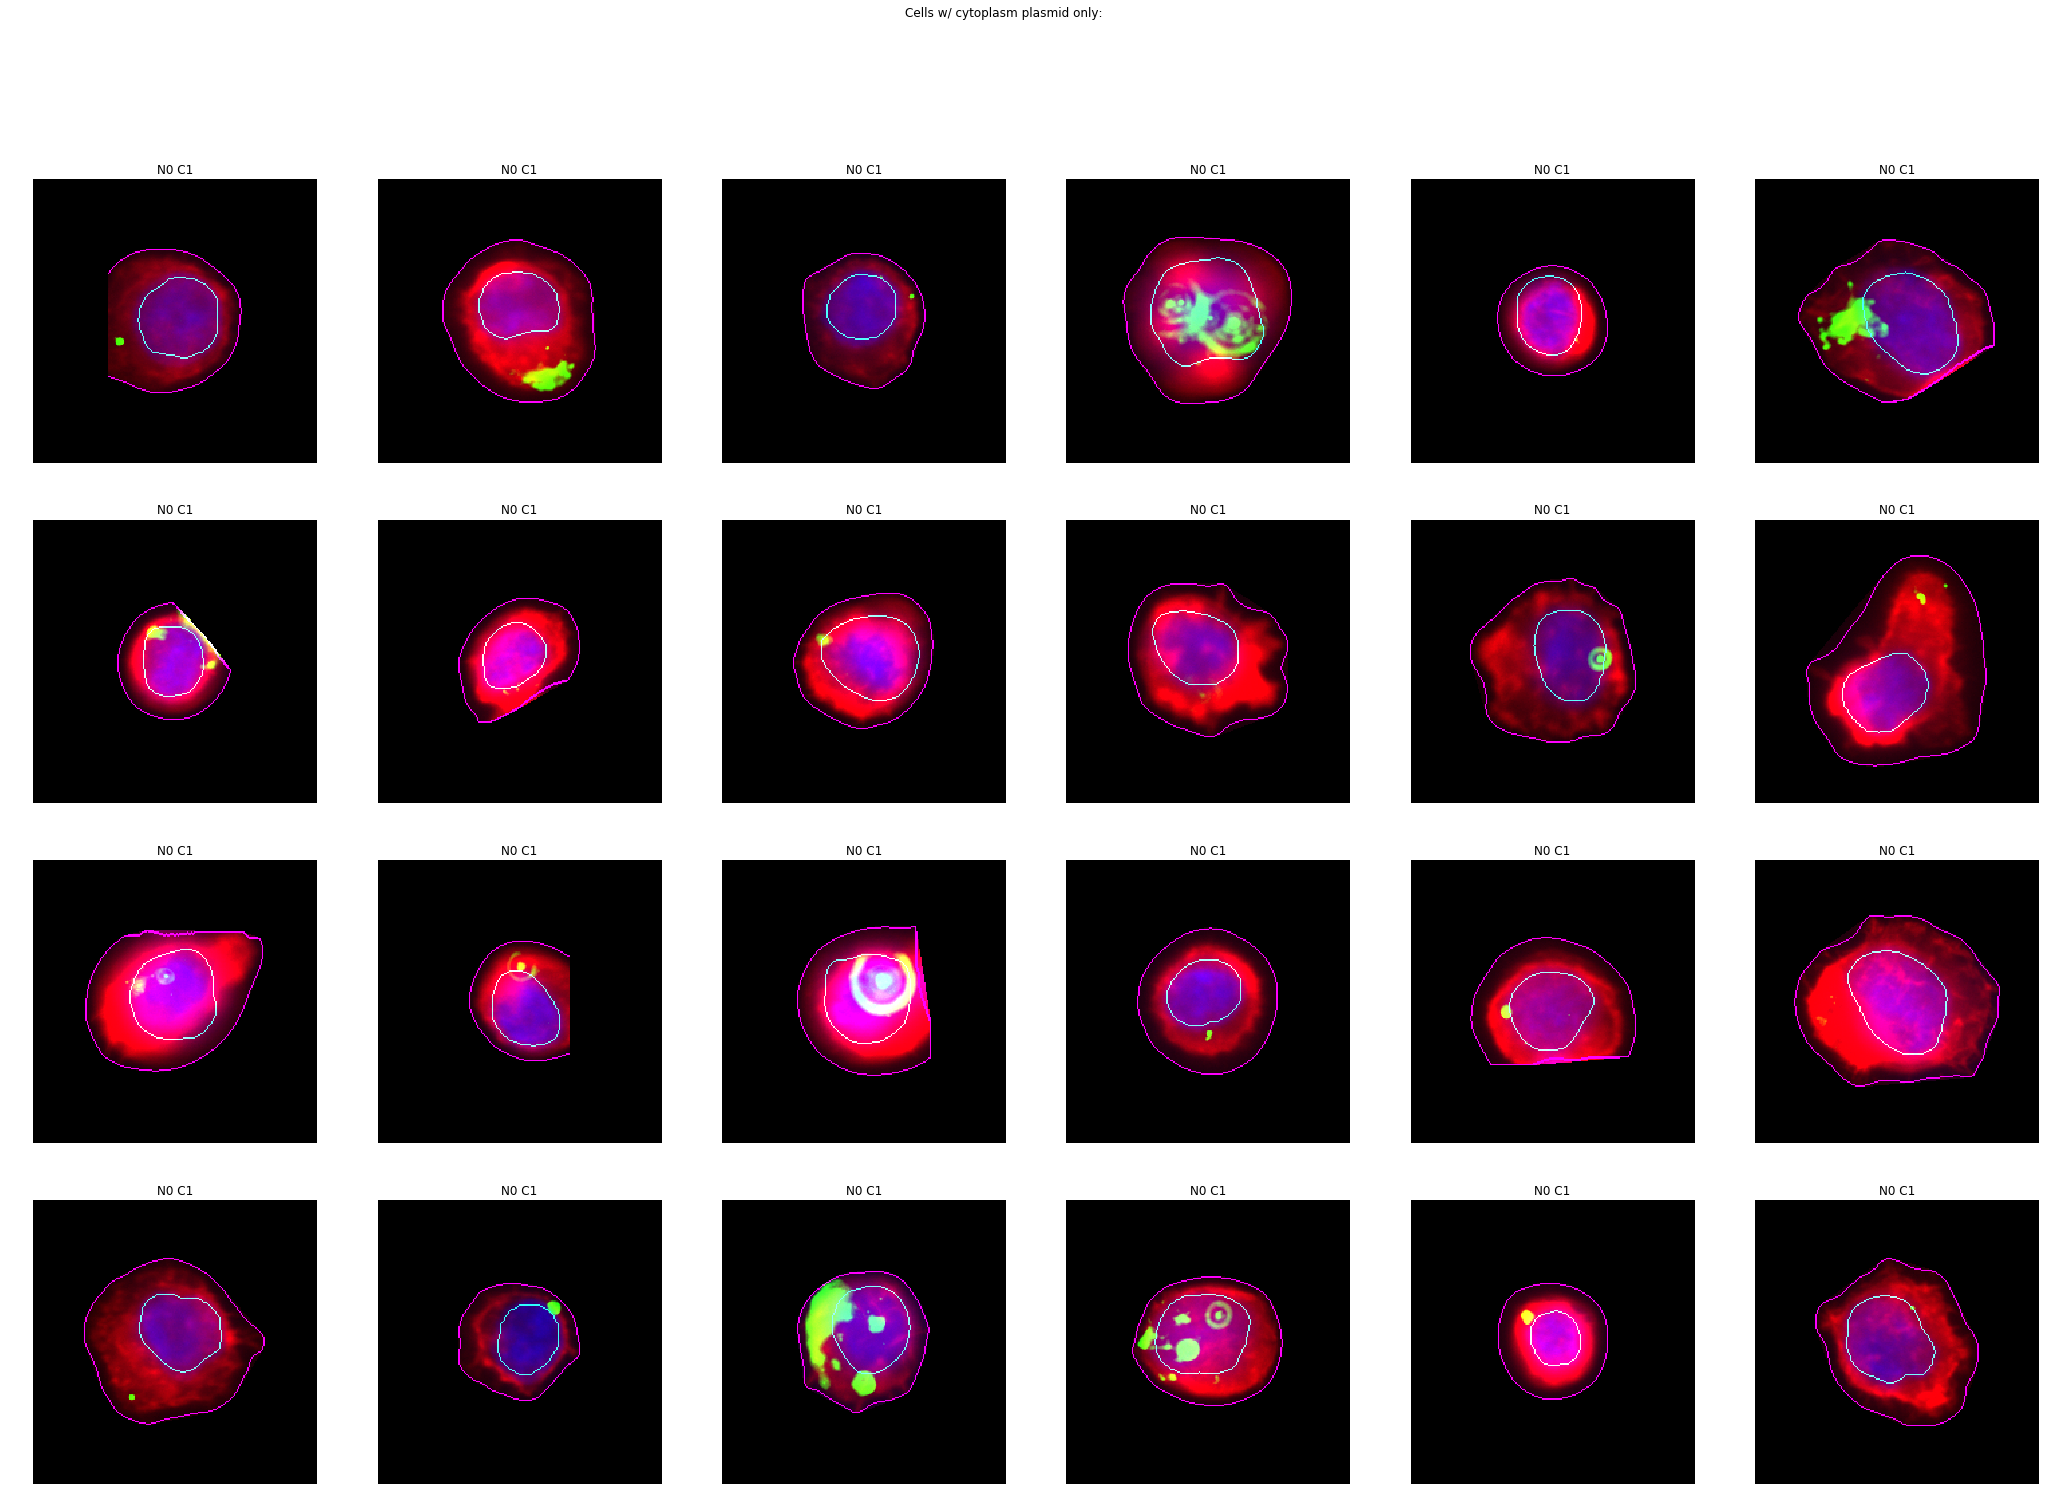

In [12]:
def plot_cells(df, ncol=6, title=''):
    n = len(df)
    plt.figure()
    nrow = -(-n//ncol)
    fig, axs = plt.subplots(nrow, ncol)
    fig.suptitle(title)
    fig.set_size_inches(ncol * 6, nrow * 6)
    axs = axs.ravel()
    for i in range(len(axs)):
        axs[i].axis('off')
    for i in range(n):
        r = df.iloc[i]
        axs[i].imshow(r['image'])
        axs[i].set_title('N{} C{}'.format(r['nucleus_plasmid_count'], r['cytoplasm_plasmid_count']))

def disp():
    if not enable_single_cell_data:
        return None
    
    # Set display settings for overlay on single cell images
    thresh = exp_conf.cytometry_params['quantification_params']['spot_count_params']['threshold']
    ranges = {
        'proc_Plasmid': [thresh, 255],
        'proc_PHA': [0, 150],
        'cyto_nucleus_boundary': [0, 1],
        'cyto_cell_boundary': [0, 1]
    }
    colors = {
        'proc_DAPI': 'blue', 
        'proc_PHA': 'red', 
        'proc_Plasmid': 'green',
        'cyto_nucleus_boundary': 'cyan',
        'cyto_cell_boundary': 'magenta'
    }
    
    # Attach cell images to cytometry data frame
    dfsc = cytokit_data.get_single_cell_image_data(
        exp_output_dir, df, 'best_z_segm',
        ranges=ranges, colors=colors,
        image_size=(212, 212)
    )
    assert dfsc['image'].notnull().all()
    
    # Extract summary data 
    cols = [
        'id', 'rid', 'tile_x', 'tile_y', 'x', 'y', 'z', 
        'cell_diameter', 'nucleus_diameter',
        'cell_circularity', 'nucleus_circularity',
        'cs:Plasmid:nucleus_fraction', 
        'cs:Plasmid:nucleus_plasmid_count',
        'cs:Plasmid:cytoplasm_plasmid_count',
        'image'
    ]
    dfsc = dfsc[cols].rename(columns=lambda c: c.replace('cs:Plasmid:', ''))
    
    # Cherry-pick cells with ideal characteristics for visualization
    plot_cells(
        dfsc[(dfsc['nucleus_plasmid_count'] > 0) & (dfsc['cytoplasm_plasmid_count'] == 0)]\
        .sort_values('nucleus_plasmid_count').head(24),
        title='Cells w/ nucleus plasmid only:'
    )
    plot_cells(
        dfsc[(dfsc['cytoplasm_plasmid_count'] > 0) & (dfsc['nucleus_plasmid_count'] == 0)]\
        .sort_values('cytoplasm_plasmid_count').head(24),
        title='Cells w/ cytoplasm plasmid only:'
    )
    
    # Export to csv if export dir given
    if export_dir:
        dfsc['image'] = dfsc['image'].apply(encoding.base64_encode_image)
        print('Single cell data frame info:')
        print(dfsc.info())
        print('Exporting data frame to csv')
        path = osp.join(export_dir, 'data.csv')
        dfsc.to_csv(path, index=False)
    
disp()

### Individual Plasmid Analysis

In [13]:
def from_csv(v):
    if pd.isnull(v) or (len(v) == 0):
        return []
    return [float(x) for x in v.split(',')]

dfs = []
for i, r in df.iterrows():
    nuc_frac = np.array(from_csv(r['cs:Plasmid:nucleus_fraction']))
    assert np.all(nuc_frac <= 1)
    assert np.all(nuc_frac >= 0)
    for i in range(len(nuc_frac)):
        dfs.append((r['rid'], nuc_frac[i]))
dfs = pd.DataFrame(dfs, columns=['rid', 'nuc_frac'])
dfs.head()

,rid,nuc_frac
0,18,0.0
1,18,0.0
2,19,1.0
3,71,1.0
4,73,1.0


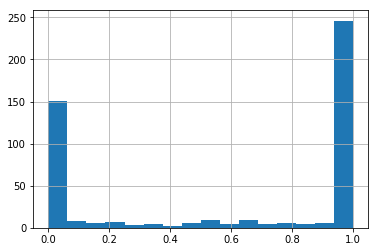

In [14]:
if enable_graphics:
    dfs['nuc_frac'].hist(bins=16)

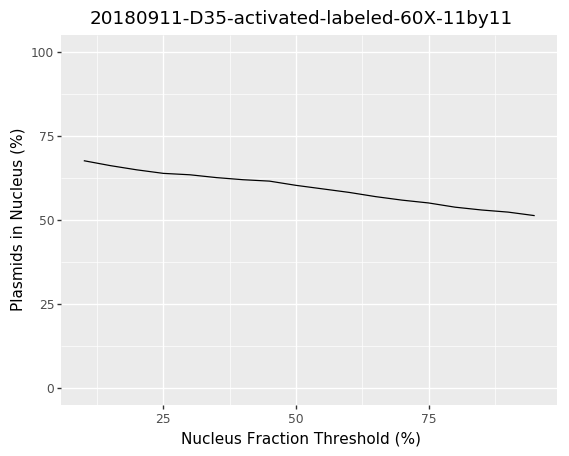

<ggplot: (8748562263823)>

In [15]:
def get_threshold_curve(dfs):
    df = []
    for thresh in np.arange(.1, 1., .05):
        p = (dfs['nuc_frac'] > thresh).mean()
        df.append((100*thresh, 100*p))
    return pd.DataFrame(df, columns=['threshold', 'p'])
    
dfsfrac = get_threshold_curve(dfs)
pm.record('nucleus_fraction_threshold', dfsfrac.set_index('threshold')['p'].to_json())

def disp():
    if not enable_graphics:
        return None
    return (
        pn.ggplot(dfsfrac, pn.aes(x='threshold', y='p')) + 
        pn.geom_line() + 
        pn.ylim(0, 100) + 
        pn.xlab('Nucleus Fraction Threshold (%)') + 
        pn.ylab('Plasmids in Nucleus (%)') +
        pn.ggtitle(exp_name)
    )
disp()

In [16]:
cts = (dfs['nuc_frac'] > nucleus_plasmid_threshold).value_counts()
pm.record('plasmids_in_nucleus:count', cts.to_json())
cts

True     250
False    227
Name: nuc_frac, dtype: int64

In [17]:
cts = (dfs['nuc_frac'] > nucleus_plasmid_threshold).value_counts(normalize=True)
pm.record('plasmids_in_nucleus:frac', cts.to_json())
cts

True     0.524109
False    0.475891
Name: nuc_frac, dtype: float64

In [18]:
desc = df['nucleus_diameter'].describe()
pm.record('nucleus_diameter', desc.to_json())
desc

count    262.000000
mean       8.025818
std        1.427380
min        4.444236
25%        6.955212
50%        7.793268
75%        9.153489
max       13.309255
Name: nucleus_diameter, dtype: float64

In [19]:
desc = df['cell_diameter'].describe()
pm.record('cell_diameter', desc.to_json())
desc

count    262.000000
mean      13.699743
std        2.312834
min        6.836509
25%       12.091294
50%       13.664540
75%       15.370225
max       19.443628
Name: cell_diameter, dtype: float64

In [20]:
desc = (df['nucleus_size'] / df['cell_size']).describe()
pm.record('nucleus_to_cell_ratio', desc.to_json())
desc

count    262.000000
mean       0.352117
std        0.084767
min        0.183227
25%        0.289356
50%        0.349692
75%        0.395997
max        0.675249
dtype: float64

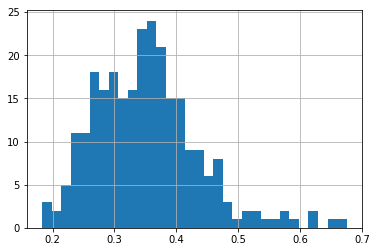

In [21]:
if enable_graphics:
    (df['nucleus_size'] / df['cell_size']).hist(bins=32)